In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

In [2]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [3]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [4]:
def build_vgg16_unet(input_shape,num_classes):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

In [5]:
input_shape = (256, 256, 3)
model = build_vgg16_unet(input_shape,2)
model.summary()


58900480/58889256 [==============================] - 1s 0us/step
Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                       

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
drive_path = '/content/drive/MyDrive/PFA' 

# Training

In [8]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, Accuracy, IoU
from sklearn.model_selection import train_test_split


In [9]:
H = 256
W = 256

def create_dir(path):
    """Create a directory"""
    if not os.path.exists(path):
        os.mkdir(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path, split=0.2):

    images = sorted(glob(f"{path}/images/*.bmp"))
    masks = sorted(glob(f"{path}/GT_full/*.bmp"))
    
    print(len(masks), len(images))

    train_x, valid_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=0.2, random_state=42)
    print(len(train_x), len(train_y), len(valid_x), len(valid_y))
   
    return (train_x, train_y), (valid_x, valid_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode('utf-8')
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x[x == 255] = 1
    x[x == 0] = 0 
    x[ x > 1] = 0
    x = x.astype(np.int32)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.int32])
    y = tf.one_hot(y, 2, dtype=tf.int32)
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 2])

    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)

    return dataset

In [10]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [11]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

"""Directory for storing files"""
create_dir("/content/drive/MyDrive/PFA/ROI_files_vgg16")

"""Hyperparameters"""
batch_size = 10
learning_rate = 1e-4
num_epochs = 30
model_path = os.path.join("/content/drive/MyDrive/PFA/ROI_files_vgg16", "model.h5")
csv_path = os.path.join("/content/drive/MyDrive/PFA/ROI_files_vgg16", "data.csv")

"""Dataset"""
dataset_path = os.path.join("/content/drive/MyDrive/PFA/new_data")
train_path = os.path.join(dataset_path, "train")

(train_x, train_y), (valid_x, valid_y) = load_data(train_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
test_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

"""Model"""

model = build_vgg16_unet((H, W, 3),2)
metrics = [dice_coef, iou, 'accuracy', Recall(), Precision()]
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=metrics)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
]

history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    epochs=num_epochs,
    validation_data=test_dataset,
    validation_steps=valid_steps,
    callbacks=callbacks
)

945 945
756 756 189 189
Train: 756 - 756
Valid: 189 - 189
Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.1988 - dice_coef: 0.8639 - iou: 0.7742 - accuracy: 0.9212 - recall: 0.9212 - precision: 0.9212
Epoch 1: val_loss improved from inf to 0.47767, saving model to /content/drive/MyDrive/PFA/ROI_files_vgg16/model.h5
75/75 [==============================] - 216s 2s/step - loss: 0.1988 - dice_coef: 0.8639 - iou: 0.7742 - accuracy: 0.9212 - recall: 0.9212 - precision: 0.9212 - val_loss: 0.4777 - val_dice_coef: 0.8817 - val_iou: 0.7885 - val_accuracy: 0.8883 - val_recall: 0.8883 - val_precision: 0.8883 - lr: 1.0000e-04
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.0665 - dice_coef: 0.9587 - iou: 0.9207 - accuracy: 0.9754 - recall: 0.9754 - precision: 0.9754
Epoch 2: val_loss improved from 0.47767 to 0.07216, saving model to /content/drive/MyDrive/PFA/ROI_files_vgg16/model.h5
75/75 [==============================] - 54s 636ms/step - loss: 0.0665 

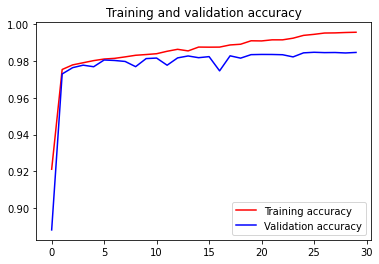

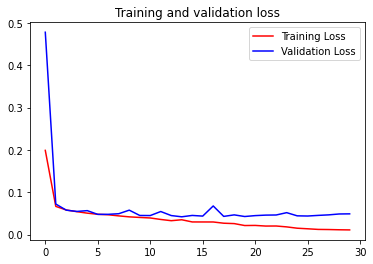

In [12]:
# Plot the chart for accuracy and loss on both training and validation
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
def load_data(path):

    images = sorted(glob(f"{path}/images/*.bmp"))
    masks = sorted(glob(f"{path}/GT_full/*.bmp"))
    
    print(len(images), len(masks))
   
    return (images, masks)
test_path = os.path.join(dataset_path, "test")
(test_x, test_y) = load_data(test_path)

48 48


In [14]:
from tqdm import tqdm

In [15]:
num_classes = 2
res_path = os.path.join(dataset_path, "results_ROI_vgg16")
create_dir(res_path)
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        name = x.split("/")[-1]

        ## Read image
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        x = x / 255.0
        x = x.astype(np.float32)
        
        ## Read mask
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        y[y == 255] = 1
        y[y == 0] = 0 
        y[y > 1] = 0
        y = np.expand_dims(y, axis=-1) ## (256, 256, 1)
        y = y * (255/num_classes)
        y = y.astype(np.int32)
        y = np.concatenate([y, y, y], axis=2)

        ## Prediction
        p = model.predict(np.expand_dims(x, axis=0))[0]
        p = np.argmax(p, axis=-1)
        p = np.expand_dims(p, axis=-1)
        p = p * (255/num_classes)
        p = p.astype(np.int32)
        p = np.concatenate([p, p, p], axis=2)

        x = x * 255.0
        x = x.astype(np.int32)

        h, w, _ = x.shape
        line = np.ones((h, 10, 3)) * 255

        print(x.shape, line.shape, y.shape, line.shape, p.shape)

        final_image = np.concatenate([x, line, y, line, p], axis=1)
        status = cv2.imwrite(f"{res_path}/{name}", final_image)
        print(status)

  0%|          | 0/48 [00:00<?, ?it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


  2%|▏         | 1/48 [00:02<02:01,  2.59s/it]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


  4%|▍         | 2/48 [00:03<01:11,  1.55s/it]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


  6%|▋         | 3/48 [00:04<00:52,  1.17s/it]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


  8%|▊         | 4/48 [00:05<00:47,  1.08s/it]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 10%|█         | 5/48 [00:05<00:43,  1.00s/it]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 12%|█▎        | 6/48 [00:06<00:39,  1.05it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 15%|█▍        | 7/48 [00:07<00:38,  1.06it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 17%|█▋        | 8/48 [00:08<00:36,  1.10it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 19%|█▉        | 9/48 [00:09<00:33,  1.15it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 21%|██        | 10/48 [00:10<00:30,  1.23it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 23%|██▎       | 11/48 [00:10<00:28,  1.30it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 25%|██▌       | 12/48 [00:11<00:27,  1.30it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 27%|██▋       | 13/48 [00:12<00:26,  1.34it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 29%|██▉       | 14/48 [00:12<00:25,  1.34it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 31%|███▏      | 15/48 [00:13<00:24,  1.35it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 33%|███▎      | 16/48 [00:14<00:23,  1.34it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 35%|███▌      | 17/48 [00:15<00:23,  1.31it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 38%|███▊      | 18/48 [00:15<00:22,  1.33it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 40%|███▉      | 19/48 [00:16<00:21,  1.35it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 42%|████▏     | 20/48 [00:17<00:21,  1.33it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 44%|████▍     | 21/48 [00:18<00:20,  1.33it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 46%|████▌     | 22/48 [00:18<00:19,  1.30it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 48%|████▊     | 23/48 [00:19<00:19,  1.31it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 50%|█████     | 24/48 [00:20<00:19,  1.22it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 52%|█████▏    | 25/48 [00:21<00:19,  1.20it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 54%|█████▍    | 26/48 [00:22<00:18,  1.21it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 56%|█████▋    | 27/48 [00:23<00:17,  1.20it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 58%|█████▊    | 28/48 [00:24<00:16,  1.20it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 60%|██████    | 29/48 [00:24<00:15,  1.20it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 62%|██████▎   | 30/48 [00:25<00:15,  1.16it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 65%|██████▍   | 31/48 [00:26<00:14,  1.19it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 67%|██████▋   | 32/48 [00:27<00:12,  1.24it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 69%|██████▉   | 33/48 [00:28<00:11,  1.28it/s]

True


 71%|███████   | 34/48 [00:28<00:10,  1.34it/s]

(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)
True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 73%|███████▎  | 35/48 [00:29<00:09,  1.33it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 75%|███████▌  | 36/48 [00:30<00:09,  1.33it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 77%|███████▋  | 37/48 [00:30<00:08,  1.34it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 79%|███████▉  | 38/48 [00:31<00:07,  1.36it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 81%|████████▏ | 39/48 [00:32<00:06,  1.34it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 83%|████████▎ | 40/48 [00:33<00:06,  1.32it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 85%|████████▌ | 41/48 [00:33<00:05,  1.30it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 88%|████████▊ | 42/48 [00:34<00:04,  1.27it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 90%|████████▉ | 43/48 [00:35<00:03,  1.27it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 92%|█████████▏| 44/48 [00:36<00:03,  1.29it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 94%|█████████▍| 45/48 [00:37<00:02,  1.33it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 96%|█████████▌| 46/48 [00:37<00:01,  1.31it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


 98%|█████████▊| 47/48 [00:38<00:00,  1.29it/s]

True
(256, 256, 3) (256, 10, 3) (256, 256, 3) (256, 10, 3) (256, 256, 3)


100%|██████████| 48/48 [00:39<00:00,  1.22it/s]

True
